[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/orduek/aversive_learning_simulation/blob/main/simulating_scrData.ipynb)

# Simulating and testing simple RW model
In this notebook we will simulate SCR data of an aversive learning task
- Simulate
- Test Maximum Likelihood extraction
- Test pymc3 model on the simulated data
- Compare different models
\

The notebook is heavily based on two these two great resources:
1. https://github.com/ricardoV94/stats/blob/master/modelling/RL_PyMC.ipynb
2. https://discourse.pymc.io/t/modeling-reinforcement-learning-of-human-participant-using-pymc3/1735

In [4]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
# import stan

import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import statsmodels.formula.api as smf

First we simulate vector of stimulus (CS+ = 1 and CS- = 0) \
Then simulate a vector of shocks (shock=1, no shock =0)


In [8]:
stimVec = [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
shockVec = [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
print(stimVec)
print(shockVec[:])

[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [10]:
shockVec = np.hstack([shockVec] *1)
stimVec = np.hstack([stimVec] * 1)

In [12]:
sum(shockVec) / sum(stimVec) # 38%

0.3888888888888889

# Simulate SCR based on stimulus and shock

In [13]:
def simulateSCR(alpha, stimVec, shockVec, intercept, slope):
    scrSim = np.zeros(len(stimVec))
    scrCSp = 0.5
    scrCSm = 0.5
    # set intercept and slopes
    for i,(s,t) in enumerate(zip(stimVec,shockVec)):
        # print(i)
        # print(f'Stim is {s}')
        # print(f'Shock is{t}')
        if s==1:      
            pe = t - scrCSp   # prediction error
            scrCSp = scrCSp + alpha*pe
            scrSim[i] = scrCSp
        if s==0:
            pe = t - scrCSm   # prediction error
            scrCSm = scrCSm + alpha*pe
            scrSim[i] = scrCSm
        # add intercept and slope
        scrSim[i] = scrSim[i] + np.random.normal(0,.1) # add noise #
        
        scrSim[i] =  slope*scrSim[i]
        
    return scrSim

In [25]:
# generate 10 subjects with different alphas
n_subj = 10 # number of subjects
alphalist = []
interceptList = []
slopeList = []

subjects = np.empty([shockVec.shape[0],n_subj]) # create an empty matrix of trials X subjects
for i in np.arange(n_subj):
   # print(i)
    alpha = np.random.beta(a=1,b=1)
    intercept = np.random.normal(0,1)
    slope = np.random.normal(0,1)
    subjects[:,i] = simulateSCR(alpha, stimVec, shockVec, intercept, slope)
    alphalist.append(alpha)
    interceptList.append(intercept)
    slopeList.append(slope)

In [26]:
subjects.shape

(30, 10)

# Test logp with MLE
Here we first use the RW model to extract the $\alpha$ (learning rate) of each subject

In [16]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    stim, shock, scr  = args
    
    scrSim = np.zeros(len(stim))
    scrCSp = 0.5
    scrCSm = 0.5
    # set intercept and slopes
    for i,(s,t) in enumerate(zip(stim,shock)):
       
        if s==1:      
            pe = t - scrCSp   # prediction error
            scrCSp = scrCSp + alpha*pe
            scrSim[i] = scrCSp
        if s==0:
            pe = t - scrCSm   # prediction error
            scrCSm = scrCSm + alpha*pe
            scrSim[i] = scrCSm
        # add intercept and slope
        scrSim[i] = scrSim[i] 
        
        scrSim[i] =  beta*scrSim[i]
   
    scrPred = scrSim
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(scipy.stats.norm.logpdf(scr, scrPred))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 
    

Optimizing the likelihood
- We will get a list of alpha and slope per subject

In [17]:
logSub = []
estLog = []
for i in np.arange(n_subj):
    x0 = [alphalist[i], slopeList[i]]
    estLog.append(scipy.optimize.minimize(llik_td, x0, args=(stimVec,shockVec , subjects[:,i]), method='L-BFGS-B'))
    print(estLog[i].x)

[ 0.292833   -0.01585205]
[ 0.89944305 -0.30031462]
[ 0.92926854 -0.12836659]
[0.08399216 1.68311358]
[0.92642053 0.36312567]
[0.27037335 0.97253865]
[ 0.90282192 -0.26311115]
[ 0.95320509 -1.12880985]
[0.23337722 0.10064373]
[ 0.82462496 -0.42777693]


Compare to actual values

In [18]:
print(f'Alphas {alphalist}\nSlopes {slopeList}')

Alphas [0.29253817378965086, 0.8629301947316974, 0.9246810700086434, 0.0801599312874431, 0.9090607385565922, 0.2453775296154726, 0.8575869746044947, 0.9479997945421589, 0.31071809024413805, 0.828829467455965]
Slopes [-0.015350787397765684, -0.3399462576132514, -0.1234733395421933, 1.6323439504040627, 0.35801389799367195, 0.9187054477941142, -0.2870036842819805, -1.1198339578558987, 0.10485300159125356, -0.42076112688765976]


Recovery is relatively ok

# Test the PyMC code
- We start with building an update_Q function that updates the value of of each stimulus in each trial
- Because our observed variable is SCR per trial, we extract a vector with expected value per the relevant trial

In [44]:
#scrs = tt.zeros(30) # set empty scr tensor (vector)
   
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
     
    PE = shock - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

def theano_llik_td(alpha,  stim, shock, n_subj):
   # stim = theano.shared(np.asarray(stim, dtype='int16'))
   # shock = theano.shared(np.asarray(shock, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
    
   
    return Qs, vec

Now move everything to theano and generate indexing for subjects, trials etc.

In [21]:
n_subj = subjects.shape[1]
n_trials=stimVec.shape[0]

trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj = tt.as_tensor_variable(subj.T)


In [22]:
# organize the vectors to feed
stim =np.reshape([stimVec]*n_subj, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape([shockVec]*n_subj, (n_subj,n_trials)).T


In [23]:
# turn to tensores
stim = tt.as_tensor_variable(stim)
shock = tt.as_tensor_variable(shock)

In [48]:
# test the function first
results, vec = theano_llik_td(alphalist, stim, shock, n_subj)

In [49]:
vec.eval().shape

(30, 10, 1)

# Now Comparing Different Models
- Now we can test which of the models recovers the known $\alpha$ from the data

In [51]:
# try alpha as beta distribution
with pm.Model() as mB:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=subjects) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.


In [52]:
az.summary(trB, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.140,0.081,0.010,0.291,0.001,0.001,2824.0,1512.0,1.0
alpha[1],0.709,0.182,0.397,0.999,0.003,0.002,3882.0,2135.0,1.0
alpha[2],0.300,0.017,0.269,0.332,0.000,0.000,5138.0,3242.0,1.0
alpha[3],0.744,0.159,0.472,1.000,0.002,0.002,3799.0,1847.0,1.0
alpha[4],0.462,0.269,0.021,0.921,0.004,0.003,4613.0,2604.0,1.0
alpha[5],0.390,0.234,0.003,0.815,0.004,0.003,3367.0,1756.0,1.0
alpha[6],0.696,0.020,0.659,0.731,0.000,0.000,3532.0,2910.0,1.0
alpha[7],0.709,0.070,0.577,0.841,0.001,0.001,4274.0,2237.0,1.0
alpha[8],0.572,0.061,0.457,0.689,0.001,0.001,3808.0,2549.0,1.0
alpha[9],0.517,0.177,0.190,0.847,0.003,0.002,3015.0,2116.0,1.0


In [53]:
#slopeList
print(alphalist)

[0.08598412304674652, 0.8251625236377906, 0.37879936207637654, 0.8504167076811493, 0.2144552072802054, 0.2597169394236822, 0.7176683939162277, 0.7233651693601585, 0.59028091283681, 0.5139323281223185]


## Recovering ok but not perfect
- Lets add hierarchy to see how helpful this can be

## Use both $\alpha$ and $\beta$ as pooled

In [68]:
# try alpha as beta distribution
with pm.Model() as m_H:
    
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=subjects) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_hB = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [69]:
az.summary(tr_hB, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.167,0.102,0.000,0.343,0.002,0.001,2615.0,1286.0,1.0
alpha[1],0.690,0.183,0.380,1.000,0.003,0.002,3159.0,1739.0,1.0
alpha[2],0.301,0.017,0.268,0.332,0.000,0.000,5694.0,2192.0,1.0
alpha[3],0.722,0.159,0.466,1.000,0.003,0.002,2861.0,1420.0,1.0
alpha[4],0.492,0.251,0.053,0.955,0.004,0.003,4175.0,2468.0,1.0
alpha[5],0.422,0.229,0.015,0.836,0.004,0.003,3377.0,1603.0,1.0
alpha[6],0.696,0.020,0.660,0.735,0.000,0.000,3999.0,2680.0,1.0
alpha[7],0.703,0.071,0.576,0.842,0.001,0.001,3900.0,2700.0,1.0
alpha[8],0.571,0.058,0.460,0.680,0.001,0.001,4587.0,2607.0,1.0
alpha[9],0.523,0.168,0.200,0.842,0.003,0.003,2768.0,1297.0,1.0


In [70]:
print(alphalist)

[0.08598412304674652, 0.8251625236377906, 0.37879936207637654, 0.8504167076811493, 0.2144552072802054, 0.2597169394236822, 0.7176683939162277, 0.7233651693601585, 0.59028091283681, 0.5139323281223185]


In [71]:
comp = az.compare({'model1':trB, 'model2': tr_hB}, ic='loo')
comp

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential obse

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,389.454238,24.852449,0.00000,1.0,28.360882,0.000000,True,log
model2,1,388.960479,25.082666,0.49376,0.0,28.375920,0.345765,True,log


Models perform relatively the same

<AxesSubplot:xlabel='Log'>

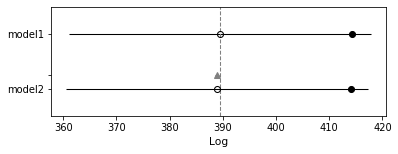

In [72]:
az.plot_compare(comp)

# Correlate expected value and subject data

In [77]:
# stack all chains
a = trB.posterior.stack(draws=('chain','draw'))
a = a.expected_value

In [78]:
mean_a = np.mean(a, axis=2)
mean_a.shape

(30, 10)

In [79]:
# calculate 
for i in np.arange(10):
    cor1 = scipy.stats.pearsonr(subjects[:,i], mean_a[:,i])
    print(cor1)

(0.7580964634564524, 1.2195238400051906e-06)
(0.9482221842617782, 1.773841236203829e-15)
(0.8860133424930073, 7.529099386035203e-11)
(0.9612313225744649, 3.346646126642093e-17)
(0.7902888769801648, 2.051125749112005e-07)
(0.8410364382994959, 5.927888218925415e-09)
(0.9734795343356426, 1.7731851926101837e-19)
(0.960113878599536, 4.9474930105288993e-17)
(0.9523743701437635, 5.647518480809706e-16)
(0.9481073973549226, 1.8283924944317867e-15)


# The Pearce-Hall Hybrid model
This is an attempt to build the PH Hybrid model.
This model doesn't assume a simple constant learning rate (as the RW), rather, it incorporated both a constant learning rate and a dynamic one. The dynamic one is being updated by the amount of new information given.
The model goes like that: \
(1) Vi(k+1) = Vi (k) + $\kappa \alpha$(k)$\delta$ \
(2) $\delta$ = shock - Vi(k) \
(3) $\alpha$(k+1) = $\eta |\delta|$ + (1 - $\eta)\alpha$(k)

So the current value is an update of the previous one plus a constant learning rate (kappa) and an associability weight (alpha) (times the delta = prediction error)
The $\alpha$ is set by a constant weight of associability (eta) and the previous $\alpha$ \

So now, our updating function will include those elements as well

In [19]:
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,alpha,assoc,
             eta,kappa, n_subj):
    """
    This function updates the Q table according to Hybrid PH model
    For information, please see this paper: https://www.sciencedirect.com/science/article/pii/S0896627316305840?via%3Dihub
  
    """
      
    delta = shock - Qs[tt.arange(n_subj), stim]
    alpha = tt.set_subtensor(alpha[tt.arange(n_subj), stim], eta * abs(delta) + (1-eta)*alpha[tt.arange(n_subj), stim])
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + kappa*alpha[tt.arange(n_subj), stim] * delta)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    # we use the same idea to get the associability per trial
    assoc = tt.set_subtensor(assoc[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                alpha[tt.arange(n_subj),1], alpha[tt.arange(n_subj),0])))
    
    return Qs, vec, alpha, assoc

In [27]:
with pm.Model() as m:
  
    # hyperpriors for eta and kappa
    phi = pm.Uniform("phi", lower=0.0, upper=1.0, shape=2)
    
    # κ   
    k_log1 = pm.Exponential("k_log1", lam=1.5)
    k1 = pm.Deterministic("k1", tt.exp(k_log1))
    kappa = pm.Beta("kappa", alpha=phi[0] * k1, beta=(1.0 - phi[0]) * k1, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    # η
    k_log2 = pm.Exponential("k_log2", lam=1.5)
    k2 = pm.Deterministic("k2", tt.exp(k_log2))
    eta = pm.Beta('η', alpha=phi[1] * k2, beta=(1.0 - phi[1]) * k2, shape=n_subj)
    
   # kappa = pm.Beta('kappa', 1,1, shape=n_subj)
   # eta = pm.Beta('eta', 1,1, shape=n_subj)
    
  #  beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    alpha = 0 * tt.ones((n_subj,2), dtype='float64')
    assoc = 0 * tt.ones((n_subj,1), dtype='float64')
    
    [Qs,vec, alpha, assoc], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, alpha, assoc],
        non_sequences=[eta, kappa, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=subjects) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add associabillity
    #assoc = pm.Deterministic('alpha', assoc)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, η, k_log2, beta, beta_sd, beta_h, kappa, k_log1, phi]


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 397 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some

In [32]:
az.summary(tr, var_names='η')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
η[0],0.624,0.264,0.185,1.000,0.007,0.005,1275.0,1215.0,1.00
η[1],0.631,0.295,0.104,1.000,0.007,0.005,1455.0,1233.0,1.00
η[2],0.701,0.266,0.182,1.000,0.011,0.008,511.0,282.0,1.01
η[3],0.649,0.161,0.418,1.000,0.004,0.003,1685.0,888.0,1.00
η[4],0.615,0.296,0.098,1.000,0.006,0.004,1787.0,1140.0,1.00
η[5],0.537,0.145,0.282,0.821,0.003,0.002,2948.0,1593.0,1.00
η[6],0.935,0.068,0.800,1.000,0.002,0.001,824.0,693.0,1.00
η[7],0.676,0.270,0.178,1.000,0.011,0.008,576.0,270.0,1.01
η[8],0.441,0.086,0.283,0.600,0.002,0.001,2966.0,2116.0,1.00
η[9],0.493,0.309,0.038,1.000,0.009,0.006,1003.0,897.0,1.00


Not surprising, but this model doesn't fit the current simulated data so well. Which is reasonable, as the simulation was built based on the RW model.
I hope to build a more specific simulation for the PH model later on. For now, we just keep it as an example